# Mean Absolute Error (MAE)

In [1]:
from scores.continuous import mae

In [2]:
# Uncomment the line below to view detailed help information on the arguments to the MAE function
# help(mae)

MAE is a fair measure of error if you are forecasting the median value. The units of MAE match the units of the forecast and observation. It is not sensitive to outliers, such as occasionally faulty forecasts or observations.

Minimising the MAE can be used as a training or objective function for machine learning to obtain a forecast that is the median of a full probabilistic forecast.

In [3]:
import numpy
import xarray
import matplotlib.pyplot as plt

In [4]:
# Import some gridded forecasts and one gridded analysis to use in trying mse
forecast = xarray.open_dataset('forecast_grid.nc')
analysis = xarray.open_dataset('analysis_grid.nc')

## Spatial Structure of Change
Exploring the example forecast you will see it provides 240 predictions, being every hour for 10 days. We will start by doing something a little surprising - which is using mae to compute the mean absolute difference of the forecasts (at all lead times) compared to the first predicted hour. While this says nothing about forecast accuracy, it does allow us to visualise which parts of the globe change more than others through the period.

This answers the question "over the next ten days, which parts of the earth are likely to experience the greatest changes in temperature on average".

In this image, the effect of the land masses can be clearly seen, showing that temperature over land changes differently to temperature over the ocean.

In [5]:
# Use mae to calculate Mean Absolute Difference of Predictions compared to first time step
fcst_diff = mae(forecast.temp_scrn,forecast.temp_scrn[0], reduce_dims='time')
fcst_diff.name = "Mean Forecast Change"
fcst_diff = fcst_diff.assign_attrs(units="Celsius")

Text(0.5, 1.0, 'Surface Temperature')

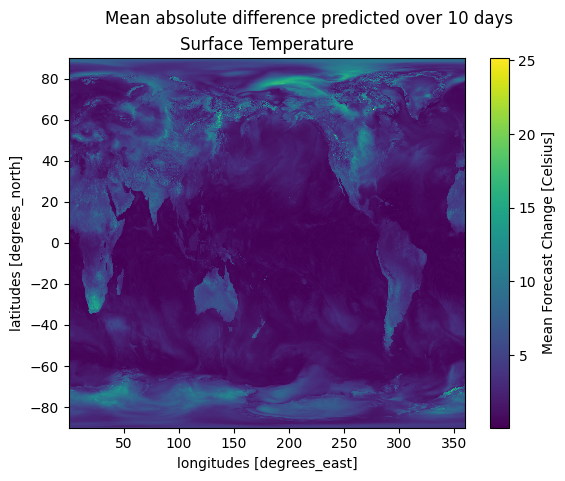

In [6]:
# Figure One - Mean Absolute Difference of Predictions compared to first time step
fcst_diff.plot()
plt.suptitle('Mean absolute difference predicted over 10 days')
plt.title('Surface Temperature')

## Matching the Forecast Lead Time and to Observations

To check whether a forecast is accurate, we need to match it to the observations (here taken as an analysis grid - an explanation of which is out of scope for this tutorial) to see how things turned out. We want to compare the analysis to the forecast valid at the time of the analysis. To do this, we need to introduce a few concepts about how a forecast model works. 

A forecast model takes into account recent observations, and then predicts forward. The latest time at which observations are included, after which actual predictions start, is called the *base time*. The model predicts forward in time from the base time. There is typically some interval, often one hour, between the base time and the first prediction. The validity start time defines the time for which the a prediction is made. The final validity time is the farthest time into the future for which a prediction is made. The lead time is the validity time minus the base time.

In this example (using the downloaded data), the base time for the forecast data can be found in the metadata as 20th November 2022, at 0000 UTC. Its first predicted hour is 0100 UTC on the 20th of November 2022. If using synthetic data, it does not include the base time in its metadata but the validity period is the same.

In [7]:
# The validity period extends from 01 UTC on the 20th of November 2022, to 00 UTC on the 30th of November 2022.
print(min(forecast.time).values)
print(max(forecast.time).values)

2022-11-20T01:00:00.000000000
2022-11-30T00:00:00.000000000


The analysis time we have available is the 24th of November at 0000 UTC. This is four days into the forecast period and has a lead time of 96 hours. We determine that the forecast time step which matches this analysis time is 24*4-1. The minus one allows for the hour between the base time and the first validity time. 
We check these time stamps below.

In [8]:
print(analysis.time.values)

['2022-11-24T00:00:00.000000000']


In [9]:
print(forecast.time[24*4-1].values)

2022-11-24T00:00:00.000000000


In [10]:
# Extract the forecast of interest
forecast_of_interest = forecast.temp_scrn[24*4-1]
forecast_of_interest

<xarray.DataArray 'temp_scrn' (lat: 1536, lon: 2048)> Size: 13MB
[3145728 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 8B 2022-11-24
  * lat      (lat) float64 12kB 89.94 89.82 89.71 89.59 ... -89.71 -89.82 -89.94
  * lon      (lon) float64 16kB 0.08789 0.2637 0.4395 ... 359.6 359.7 359.9
Attributes:
    grid_type:   spatial
    level_type:  single
    units:       K
    long_name:   screen level temperature
    stash_code:  3236
    accum_type:  instantaneous

We now have a matching forecast and observation. If we plot them, they look pretty similar!

Text(0.5, 1.0, 'Forecast at 00Z 24-11-2022')

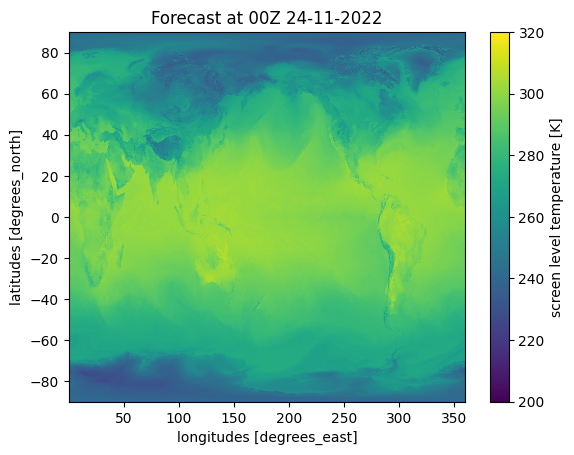

In [11]:
forecast_of_interest.plot(vmin=200, vmax=320)
plt.title('Forecast at 00Z 24-11-2022')

Text(0.5, 1.0, 'Analysis at 00Z 24-11-2022')

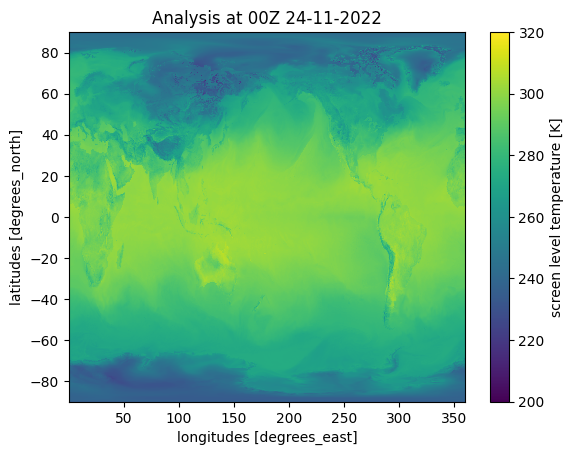

In [12]:
analysis.temp_scrn.plot(vmin=200, vmax=320)
plt.title('Analysis at 00Z 24-11-2022')


This close similarity means it is hard to pick out differences by eye alone. Scores and metrics can reveal issues and patterns. First we calculate the aggregate error for the entire planet as a single number.

In [13]:
mae(forecast_of_interest, analysis.temp_scrn).values.round(2)

1.45

In [14]:
forecast_of_interest > 280

<xarray.DataArray 'temp_scrn' (lat: 1536, lon: 2048)> Size: 3MB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
    time     datetime64[ns] 8B 2022-11-24
  * lat      (lat) float64 12kB 89.94 89.82 89.71 89.59 ... -89.71 -89.82 -89.94
  * lon      (lon) float64 16kB 0.08789 0.2637 0.4395 ... 359.6 359.7 359.9

In [15]:
import operator

In [20]:
forecast_events = operator.gt(forecast_of_interest, 280)
observed_events = operator.gt(analysis.temp_scrn, 280)

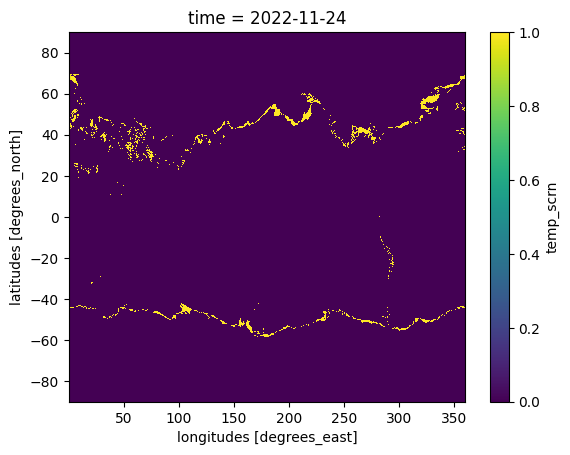

In [34]:
((forecast_events == 0 ) == observed_events).plot()

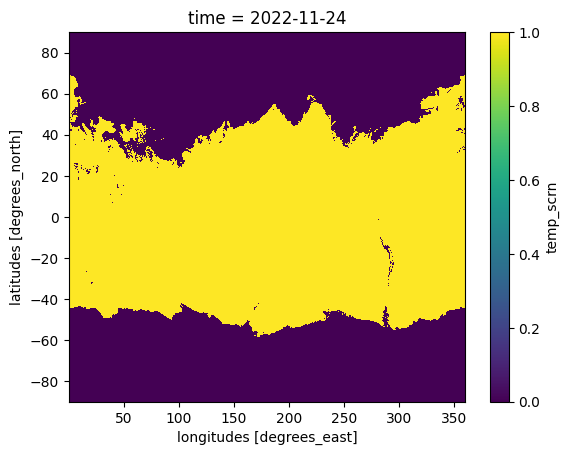

In [18]:
hot.plot()

This is interesting, but also raises questions. A forecast for four days ahead which is only, on average, about a degree and a half wrong sounds pretty impressive. But what about all that spatial structure we saw earlier? The mean absolute error function can be used to investigate that question. 

We use the `reduce_dims` argument to average over latitude, to compare mean errors at different longitudes. 

In [ ]:
mae_by_longitude = mae(forecast_of_interest, analysis.temp_scrn, reduce_dims='lat')
mae_by_longitude.name = "MAE"
mae_by_longitude = mae_by_longitude.assign_attrs(units="Celsius")

mae_by_longitude.plot()
plt.title('MAE')

We use the `preserve_dims` argument to allow us to compare mean errors at different longitudes. Using `reduce_dims='lon'` would give the same result.

In [ ]:
mae_by_latitude = mae(forecast_of_interest, analysis.temp_scrn, preserve_dims='lat')
mae_by_latitude.name = "MAE"
mae_by_latitude = mae_by_latitude.assign_attrs(units="Celsius")

mae_by_latitude.plot()
plt.title('MAE')

We can see that forecast errors generally increase towards the poles. Restricting the data to between +/- 50 degrees latitude could reveal a different story. Further analysis can be done by examining specific geographic areas of interest (such as countries, mountainous areas, or other types of spatial query).

An additional point to be aware of is the different area represented by each point on this grid. Due to the way that the projection of the earth onto a rectangular grid works, the mid-latitudes represent a much larger amount of area than the polar latitudes. We could allow for this with a latitude-weighted score to weight each forecast point relative to the area it represents.

## Things to try next

Explore the `weights` option within mae. The tutorial Weighting_Results might assist with this.

Explore the `angular` option within mae, relevant if forecasting direction in degrees.

Explore the Mean_Squared_Error and Root_Mean_Squared_Error tutorials which compare mse and rmse to mae.